Loading and preprocessing data...

Performing exploratory analysis...


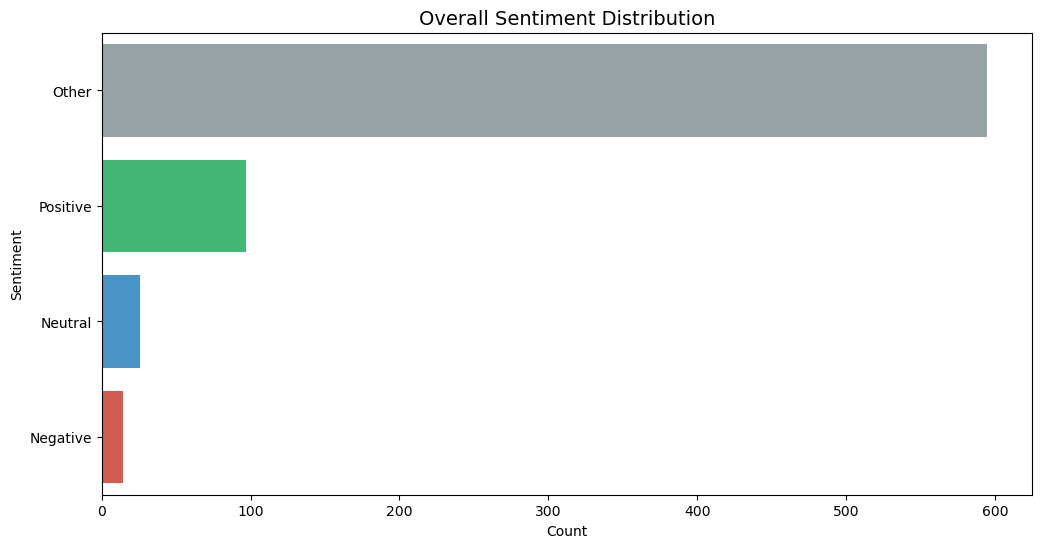


Platform Analysis:
               mean  count
Platform                  
Instagram  0.107448    258
Twitter    0.089967    243
Facebook   0.082204    231


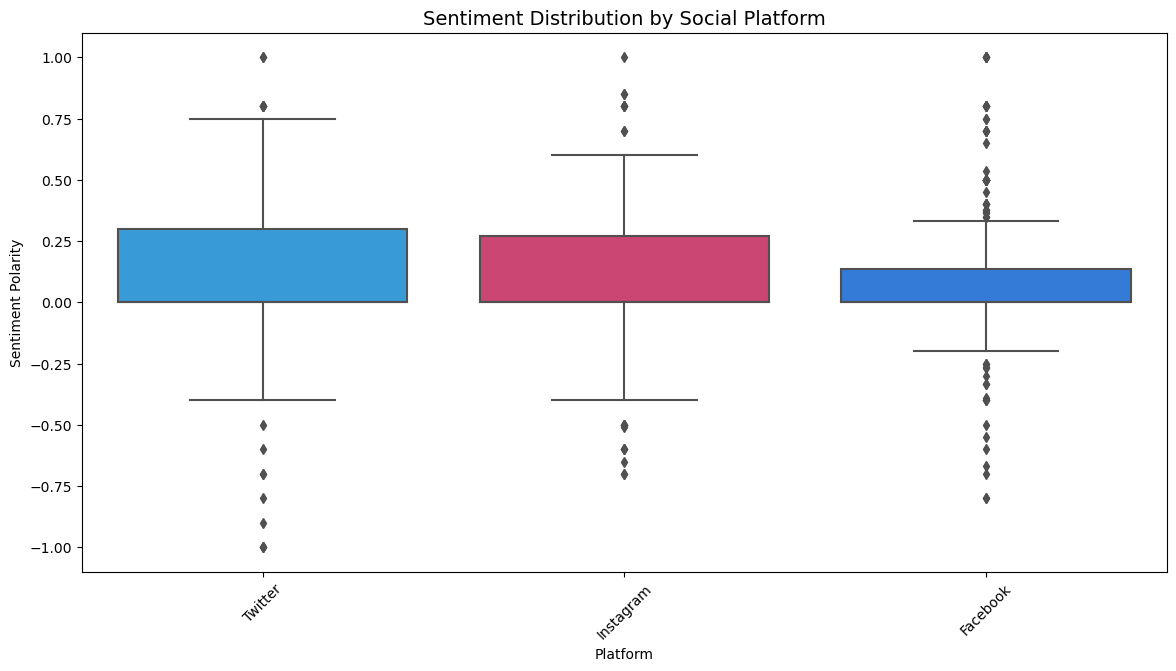

<Figure size 1600x800 with 0 Axes>

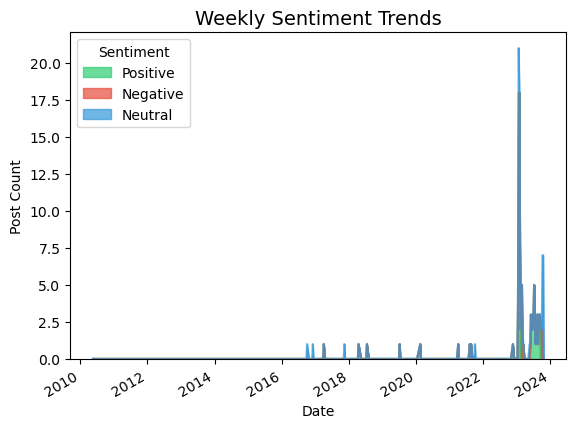

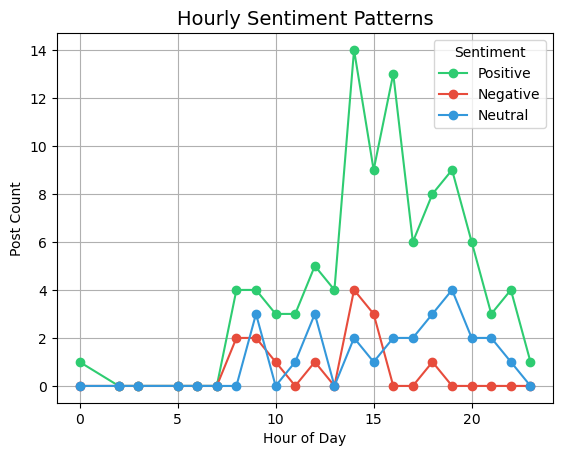


Analyzing hashtags...


<Figure size 1400x800 with 0 Axes>

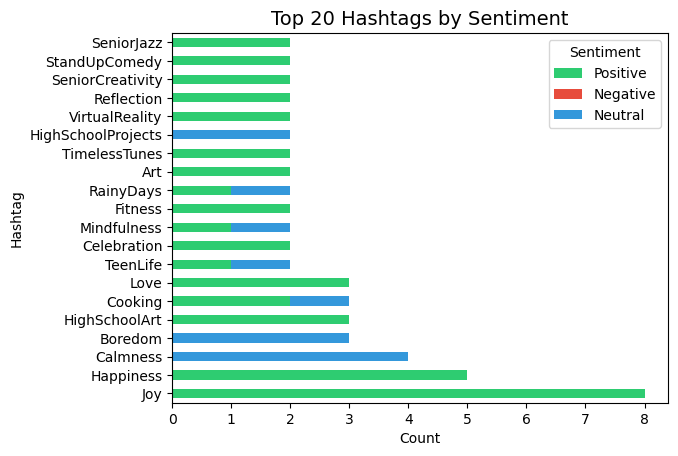

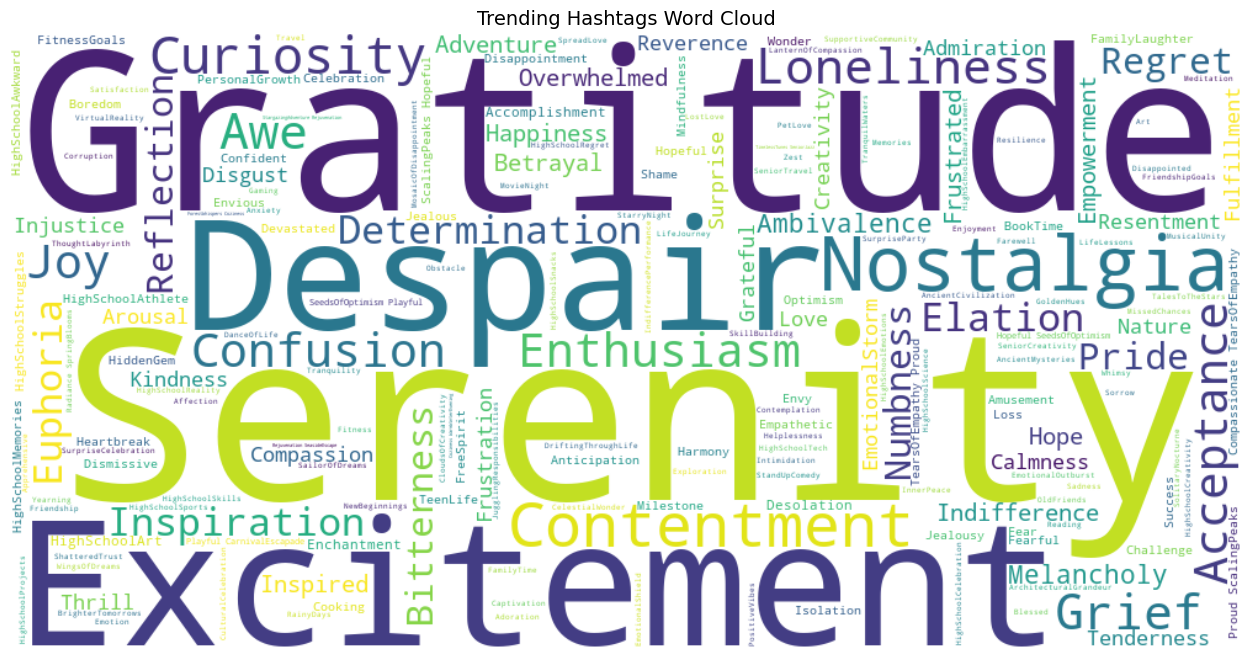


Engagement Analysis:
                     Likes   Retweets
Sentiment_Group                      
Positive         44.103093  22.072165
Other            43.163025  21.636975
Negative         36.428571  18.285714
Neutral          35.923077  18.192308


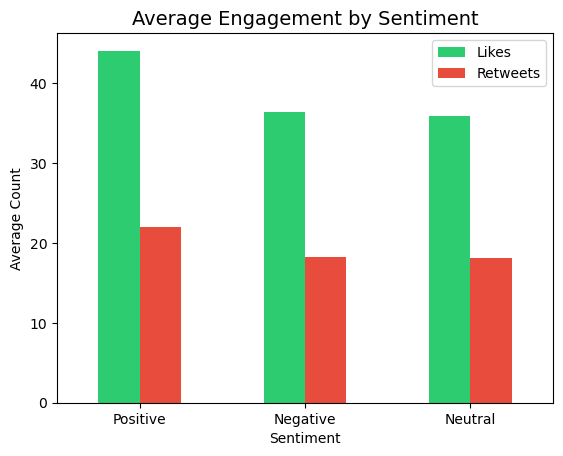

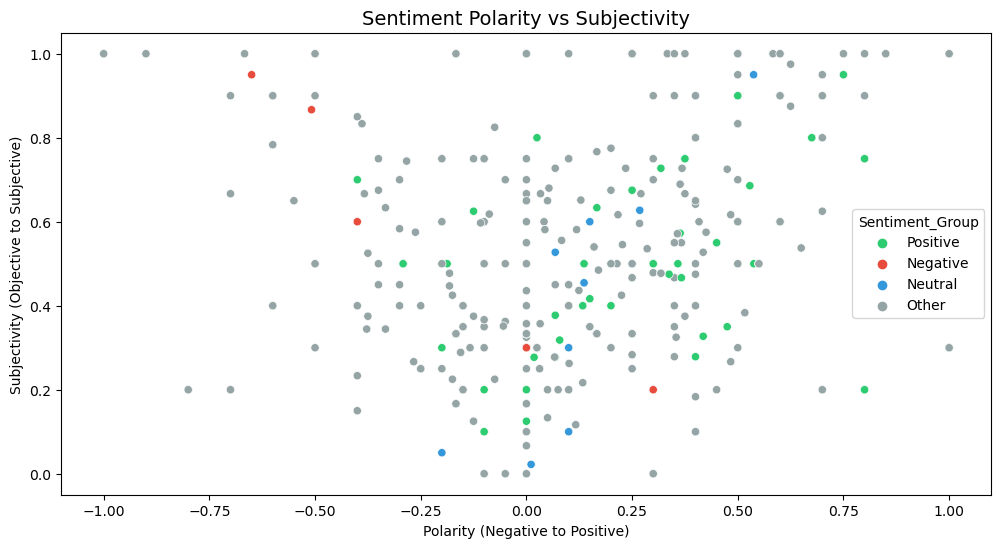


Performing text analysis...
Generating word clouds...


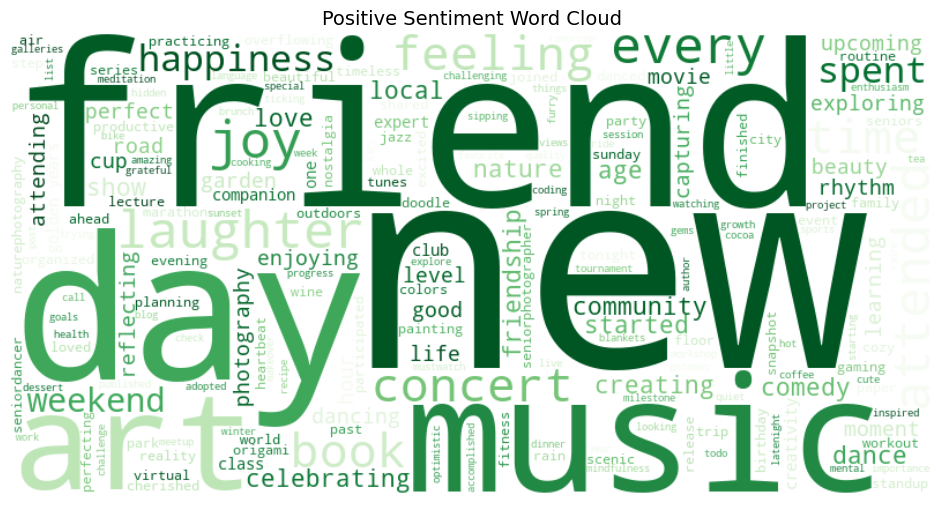

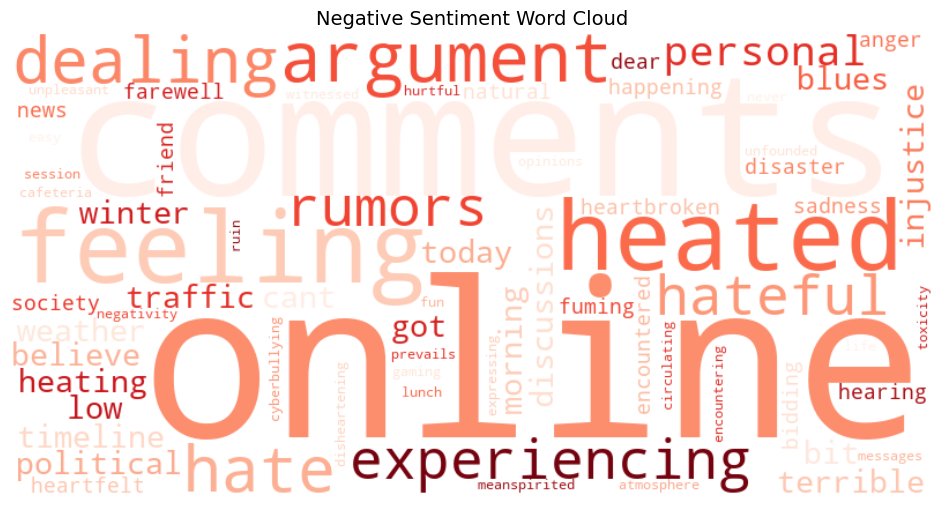

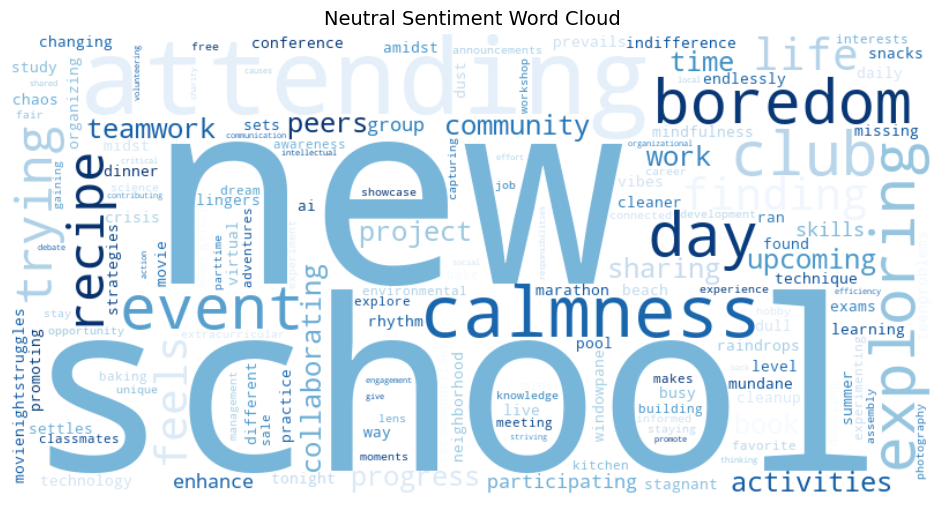

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.00      0.00      0.00         9
    Positive       0.64      1.00      0.78        18

    accuracy                           0.64        28
   macro avg       0.21      0.33      0.26        28
weighted avg       0.41      0.64      0.50        28



In [4]:
# =============================================
# SOCIAL MEDIA TREND ANALYSIS - FUTURE INTERNS
# Task 1 Enhanced Script with Fixes
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import plotly.express as px
from collections import Counter

# ====================
# 1. DATA LOADING & CLEANING
# ====================
print("Loading and preprocessing data...")
try:
    df = pd.read_csv(r'C:\Users\USER\OneDrive\Documents\Desktop\personal\future interns tasks\sentimentdataset.csv')
except FileNotFoundError:
    print("Error: File not found.")
    exit()

# Strip whitespace
df['Platform'] = df['Platform'].str.strip()
df['Sentiment'] = df['Sentiment'].str.strip()

# Clean text
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|@\w+|[^\w\s#]', '', text)
    return text.lower().strip()

df['Text_Clean'] = df['Text'].apply(clean_text)

# Group sentiments
sentiment_map = {
    'Positive': 'Positive', 'Joy': 'Positive', 'Happiness': 'Positive', 'Love': 'Positive',
    'Negative': 'Negative', 'Anger': 'Negative', 'Sadness': 'Negative', 'Hate': 'Negative',
    'Neutral': 'Neutral', 'Boredom': 'Neutral', 'Calmness': 'Neutral'
}
df['Sentiment_Group'] = df['Sentiment'].map(sentiment_map).fillna('Other')

# Sentiment scores
df['Polarity'] = df['Text_Clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Subjectivity'] = df['Text_Clean'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Fix Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Hashtags extraction
df['Hashtags_List'] = df['Hashtags'].apply(lambda x: re.findall(r'#(\w+)', str(x)))
hashtags_df = df.explode('Hashtags_List')
# ====================
# 2. EXPLORATORY ANALYSIS
# ====================
print("\nPerforming exploratory analysis...")

# Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Sentiment_Group', order=df['Sentiment_Group'].value_counts().index,
              palette={'Positive':'#2ecc71', 'Negative':'#e74c3c', 'Neutral':'#3498db', 'Other':'#95a5a6'})
plt.title("Overall Sentiment Distribution", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

# Platform Analysis
df['Platform'] = df['Platform'].str.strip()
print("\nPlatform Analysis:")
platform_stats = df.groupby('Platform')['Polarity'].agg(['mean', 'count'])
print(platform_stats.sort_values('mean', ascending=False))

plt.figure(figsize=(14, 7))
sns.boxplot(x='Platform', y='Polarity', data=df,
            palette={'Twitter':'#1DA1F2', 'Instagram':'#E1306C', 'Facebook':'#1877F2'})
plt.title("Sentiment Distribution by Social Platform", fontsize=14)
plt.ylabel("Sentiment Polarity")
plt.xlabel("Platform")
plt.xticks(rotation=45)
plt.show()

# Temporal Analysis
plt.figure(figsize=(16, 8))
weekly_trends = df.set_index('Timestamp').resample('W')['Sentiment_Group'].value_counts().unstack().fillna(0)
weekly_trends[['Positive', 'Negative', 'Neutral']].plot(kind='area', stacked=True, alpha=0.7,
                                                       color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title("Weekly Sentiment Trends", fontsize=14)
plt.ylabel("Post Count")
plt.xlabel("Date")
plt.legend(title='Sentiment')
plt.show()

hourly_sentiment = df.groupby(['Hour', 'Sentiment_Group']).size().unstack().fillna(0)
hourly_sentiment[['Positive', 'Negative', 'Neutral']].plot(
    kind='line', marker='o', color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title("Hourly Sentiment Patterns", fontsize=14)
plt.ylabel("Post Count")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.legend(title='Sentiment')
plt.show()

# Hashtag Analysis
print("\nAnalyzing hashtags...")
top_hashtags = hashtags_df.groupby(['Hashtags_List', 'Sentiment_Group']).size().unstack().fillna(0)
top_hashtags = top_hashtags.reindex(columns=['Positive', 'Negative', 'Neutral'], fill_value=0)
top_hashtags['Total'] = top_hashtags.sum(axis=1)
top_hashtags = top_hashtags.sort_values('Total', ascending=False).head(20)

plt.figure(figsize=(14,8))
top_hashtags.drop('Total', axis=1)[['Positive', 'Negative', 'Neutral']].plot(
    kind='barh', stacked=True, color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title("Top 20 Hashtags by Sentiment", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.legend(title='Sentiment')
plt.show()

all_hashtags = ' '.join(['#' + tag for tag in hashtags_df['Hashtags_List'].dropna()])
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      colormap='viridis').generate(all_hashtags)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Trending Hashtags Word Cloud", fontsize=14)
plt.show()

# Engagement Analysis
print("\nEngagement Analysis:")
engagement_stats = df.groupby('Sentiment_Group')[['Likes', 'Retweets']].mean()
print(engagement_stats.sort_values('Likes', ascending=False))

engagement_stats.loc[['Positive', 'Negative', 'Neutral']].plot(
    kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title("Average Engagement by Sentiment", fontsize=14)
plt.ylabel("Average Count")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x='Polarity', y='Subjectivity', hue='Sentiment_Group', data=df,
                palette={'Positive':'#2ecc71', 'Negative':'#e74c3c', 'Neutral':'#3498db', 'Other':'#95a5a6'})
plt.title("Sentiment Polarity vs Subjectivity", fontsize=14)
plt.xlabel("Polarity (Negative to Positive)")
plt.ylabel("Subjectivity (Objective to Subjective)")
plt.show()

# ====================
# 3. TEXT ANALYSIS
# ====================
print("\nPerforming text analysis...")

def generate_wordcloud(sentiment, color_map):
    text = ' '.join(df[df['Sentiment_Group'] == sentiment]['Text_Clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap=color_map).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment} Sentiment Word Cloud', fontsize=14)
    plt.axis('off')
    plt.show()

print("Generating word clouds...")
generate_wordcloud('Positive', 'Greens')
generate_wordcloud('Negative', 'Reds')
generate_wordcloud('Neutral', 'Blues')

# ====================
# 4. MACHINE LEARNING
# ====================
ml_df = df[df['Sentiment_Group'].isin(['Positive', 'Negative', 'Neutral'])].copy()
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(ml_df['Text_Clean'])
y = ml_df['Sentiment_Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test), zero_division=0))


# ====================
# 5. SAVE RESULTS
# ====================
df.to_csv('enhanced_sentiment_analysis_results.csv', index=False)

In [5]:
import os
os.getcwd()


'C:\\Users\\USER'